In [7]:
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score

In [8]:
# for preprocessing the data
from sklearn.preprocessing import StandardScaler

# the model
from sklearn.ensemble import RandomForestClassifier

# for combining the preprocess with model training
from sklearn.pipeline import make_pipeline

# for optimizing the hyperparameters of the pipeline
from sklearn.model_selection import GridSearchCV

<h2>Obtengo la data</h2>

In [9]:
train_values = pd.read_csv('data/train_label_enc.csv', index_col='building_id')
train_labels = pd.read_csv('data/train_labels.csv', index_col='building_id')
test_values = pd.read_csv('data/test_label_enc.csv', index_col='building_id')

In [10]:
train_values.columns

Index(['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id',
       'count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage',
       'land_surface_condition', 'foundation_type', 'roof_type',
       'ground_floor_type', 'other_floor_type', 'position',
       'plan_configuration', 'has_superstructure_adobe_mud',
       'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
       'has_superstructure_cement_mortar_stone',
       'has_superstructure_mud_mortar_brick',
       'has_superstructure_cement_mortar_brick', 'has_superstructure_timber',
       'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered',
       'has_superstructure_rc_engineered', 'has_superstructure_other',
       'legal_ownership_status', 'count_families', 'has_secondary_use',
       'has_secondary_use_agriculture', 'has_secondary_use_hotel',
       'has_secondary_use_rental', 'has_secondary_use_institution',
       'has_secondary_use_school', 'has_secondary_use_industry',
     

<h2>Me quedo con los siguientes features:</h2>

In [11]:
selected_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id',
                    'foundation_type', 'area_percentage', 'age', 'land_surface_condition',
                     'height_percentage', 'count_floors_pre_eq']

train_values_subset = train_values[selected_features]

<h2>get_dummies permite hacer un "encoding" donde cada columna categorica se transforma en varias binarias</h2>

In [7]:
#Si no tengo el dataset encodeado:
#train_values_subset = pd.get_dummies(train_values_subset)

In [28]:
train_values_subset.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,foundation_type,area_percentage,age,land_surface_condition,height_percentage,count_floors_pre_eq
building_id,,,,,,,,,
802906,6,487,12198,2,6,30,2,5,2
28830,8,900,2812,2,8,10,1,7,2
94947,21,363,8973,2,5,10,2,5,2
590882,22,418,10694,2,6,10,2,5,2
201944,11,131,1488,2,8,30,2,9,3


<h2> Utilizo optimizacion bayesiana </h2>

from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

space = {'criterion': hp.choice('criterion', ['entropy', 'gini']),
        'max_depth': hp.quniform('max_depth', 10, 1200, 10),
        'max_features': hp.choice('max_features', ['auto', 'sqrt','log2', None]),
        'min_samples_leaf': hp.uniform ('min_samples_leaf', 0, 0.5),
        'min_samples_split' : hp.uniform ('min_samples_split', 0, 1),
        'n_estimators' : hp.choice('n_estimators', [10, 50, 300, 750, 1200])
    }

def objective(space):
    model = RandomForestClassifier(criterion = space['criterion'], 
                                   max_depth = space['max_depth'],
                                 max_features = space['max_features'],
                                 min_samples_leaf = space['min_samples_leaf'],
                                 min_samples_split = space['min_samples_split'],
                                 n_estimators = space['n_estimators'], 
                                 )
    
    accuracy = cross_val_score(model, train_values_subset, train_labels.values.ravel(), cv = 4).mean()

    # We aim to maximize accuracy, therefore we return it as a negative value
    return {'loss': -accuracy, 'status': STATUS_OK }
    
trials = Trials()
best = fmin(fn= objective,
            space= space,
            algo= tpe.suggest,
            max_evals = 80,
            trials= trials)
best

<h2>make_pipeline permite enumerar automaticamente los pasos a seguir en el pipeline</h2>

In [9]:
#pipe = make_pipeline(StandardScaler(), 
#                     RandomForestClassifier(random_state=2018))
#pipe

<h2>Podemos entonces probarlo utilizando grid search</h2>

In [10]:
#param_grid = {'randomforestclassifier__n_estimators': [100, 200],
#              'randomforestclassifier__min_samples_leaf': [5, 10]}
#rf_model = GridSearchCV(pipe, param_grid, cv=5)

In [11]:
#rf_model.fit(train_values_subset, train_labels.values.ravel())

<h2>Los mejores parametros utilizando grid search son:</h2>

In [12]:
#rf_model.best_params_

In [13]:
#in_sample_preds = rf_model.predict(train_values_subset)
#f1_score(train_labels, in_sample_preds, average='micro')

<h1>Pruebo un unico caso</h1>

In [29]:
rf_model = RandomForestClassifier(random_state = 2018, n_estimators = 1000, min_samples_leaf=5, criterion = 'gini')
rf_model.fit(train_values_subset, train_labels.values.ravel())

RandomForestClassifier(min_samples_leaf=5, n_estimators=1000, random_state=2018)

In [30]:
in_sample_preds = rf_model.predict(train_values_subset)
f1_score(train_labels, in_sample_preds, average='micro')

0.8068349699348812

<h2>Una vez hecho esto podemos predecir con los tests</h2>

In [38]:
test_values_subset = test_values[selected_features]
#test_values_subset = pd.get_dummies(test_values_subset)

In [39]:
test_values_subset.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,foundation_type,area_percentage,age,land_surface_condition,height_percentage,count_floors_pre_eq
building_id,,,,,,,,,
300051,17,596,11307,2,7,20,2,6,3
99355,6,141,11987,2,13,25,2,5,2
890251,22,19,10044,2,4,5,2,5,2
745817,26,39,633,2,19,0,2,3,1
421793,17,289,7970,2,8,15,2,7,3


In [32]:
predictions = rf_model.predict(test_values_subset)

In [33]:
submission_format = pd.read_csv('uploads/submission_format.csv', index_col='building_id')


In [34]:
my_submission = pd.DataFrame(data=predictions,
                             columns=submission_format.columns,
                             index=submission_format.index)

In [35]:
my_submission.head()

,damage_grade
building_id,
300051,3
99355,2
890251,2
745817,1
421793,3


In [36]:
my_submission.to_csv('submission.csv')

<h2>Pruebas:</h2>

In [22]:
rf_model = RandomForestClassifier(random_state = 2018, n_estimators = 1000, min_samples_leaf=5, criterion = 'gini')
rf_model.fit(train_values_subset, train_labels.values.ravel())

RandomForestClassifier(min_samples_leaf=5, n_estimators=1000, random_state=2018)

In [23]:
rf_model.feature_importances_

array([0.28726971, 0.1938411 , 0.16798375, 0.07607539, 0.0822695 ,
       0.04884938, 0.02785538, 0.00173363, 0.03268402, 0.05228173,
       0.00701894, 0.01118004, 0.00394013, 0.00236141, 0.00465588])

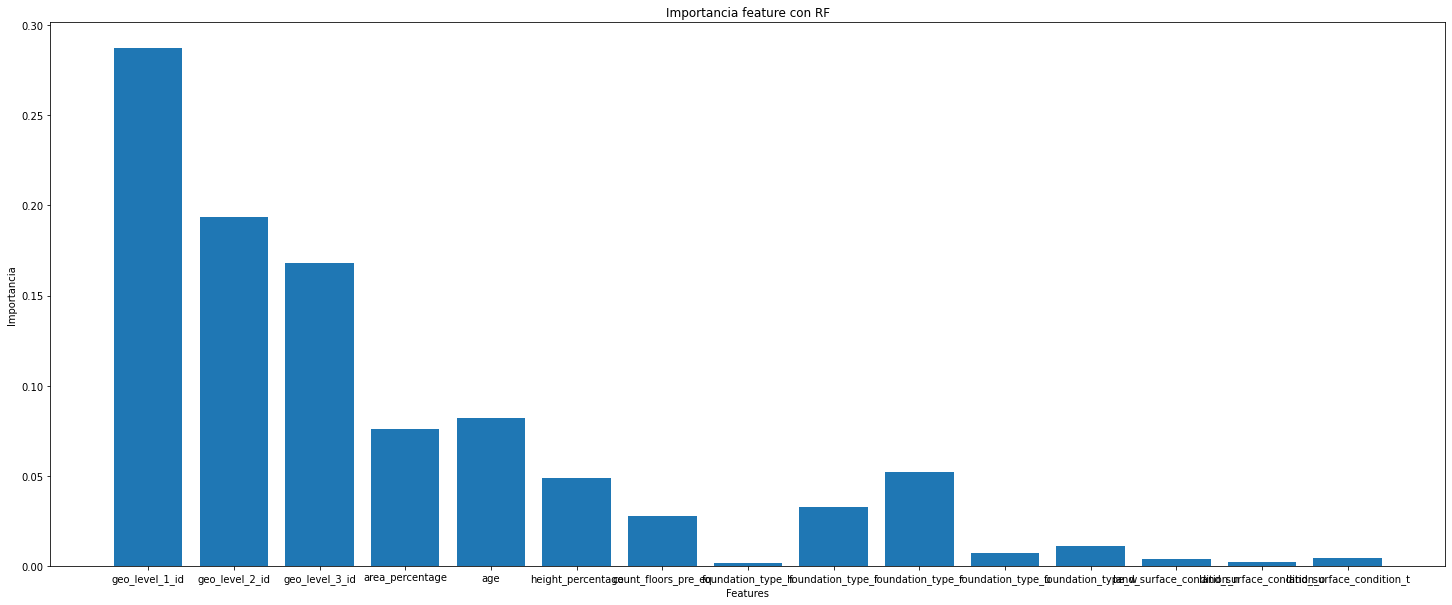

In [24]:
plt.figure(figsize=(25, 10))
plt.bar(train_values_subset.columns, rf_model.feature_importances_)
plt.xlabel('Features')
plt.ylabel('Importancia')
plt.title('Importancia feature con RF')
plt.show()